In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree,DecisionTreeRegressor
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import ValidationCurve
import matplotlib.pyplot as plt
import seaborn as sns

/Users/tanyatonoran/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/tanyatonoran/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
datapath = 'final_processed_data.csv'

# Load data

In [4]:
df = pd.read_csv(datapath)
df.head()

,age,gender,change_mood,mental_score,pop,rock,hip-hop/rap,country,classical,jazz,...,Key,Speechiness,1-2 hours,3-4 hours,Less than 1 hour,More than 5 hours,music_type_matches_mood,music_type_no_music_when_down,music_type_contrasts_mood,music_type_both
0,22,0.0,1,13.25,1,0,0,0,1,1,...,5,0.04,1,0,0,0,1,0,0,0
1,22,0.0,0,6.00,1,0,1,0,0,0,...,7,0.03,1,0,0,0,0,1,0,0
2,21,0.0,0,6.50,1,0,1,0,0,0,...,9,0.06,0,0,1,0,0,1,0,0
3,22,1.0,1,4.25,1,1,0,0,0,0,...,1,0.18,1,0,0,0,1,0,0,0
4,20,1.0,1,5.50,0,1,1,0,0,0,...,10,0.05,1,0,0,0,0,0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            327 non-null    int64  
 1   gender                         315 non-null    float64
 2   change_mood                    327 non-null    int64  
 3   mental_score                   327 non-null    float64
 4   pop                            327 non-null    int64  
 5   rock                           327 non-null    int64  
 6   hip-hop/rap                    327 non-null    int64  
 7   country                        327 non-null    int64  
 8   classical                      327 non-null    int64  
 9   jazz                           327 non-null    int64  
 10  folk                           327 non-null    int64  
 11  metal                          327 non-null    int64  
 12  electronic/dance               327 non-null    int

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,327.0,22.128440,4.840589,16.00,21.00,21.00,22.00,55.00
gender,315.0,0.485714,0.500591,0.00,0.00,0.00,1.00,1.00
change_mood,327.0,0.669725,0.471033,0.00,0.00,1.00,1.00,1.00
mental_score,327.0,4.295872,6.237364,-18.75,0.00,5.00,9.25,18.00
pop,327.0,0.770642,0.421064,0.00,1.00,1.00,1.00,1.00
rock,327.0,0.522936,0.500239,0.00,0.00,1.00,1.00,1.00
hip-hop/rap,327.0,0.559633,0.497192,0.00,0.00,1.00,1.00,1.00
country,327.0,0.082569,0.275651,0.00,0.00,0.00,0.00,1.00
classical,327.0,0.247706,0.432342,0.00,0.00,0.00,0.00,1.00
jazz,327.0,0.220183,0.415005,0.00,0.00,0.00,0.00,1.00


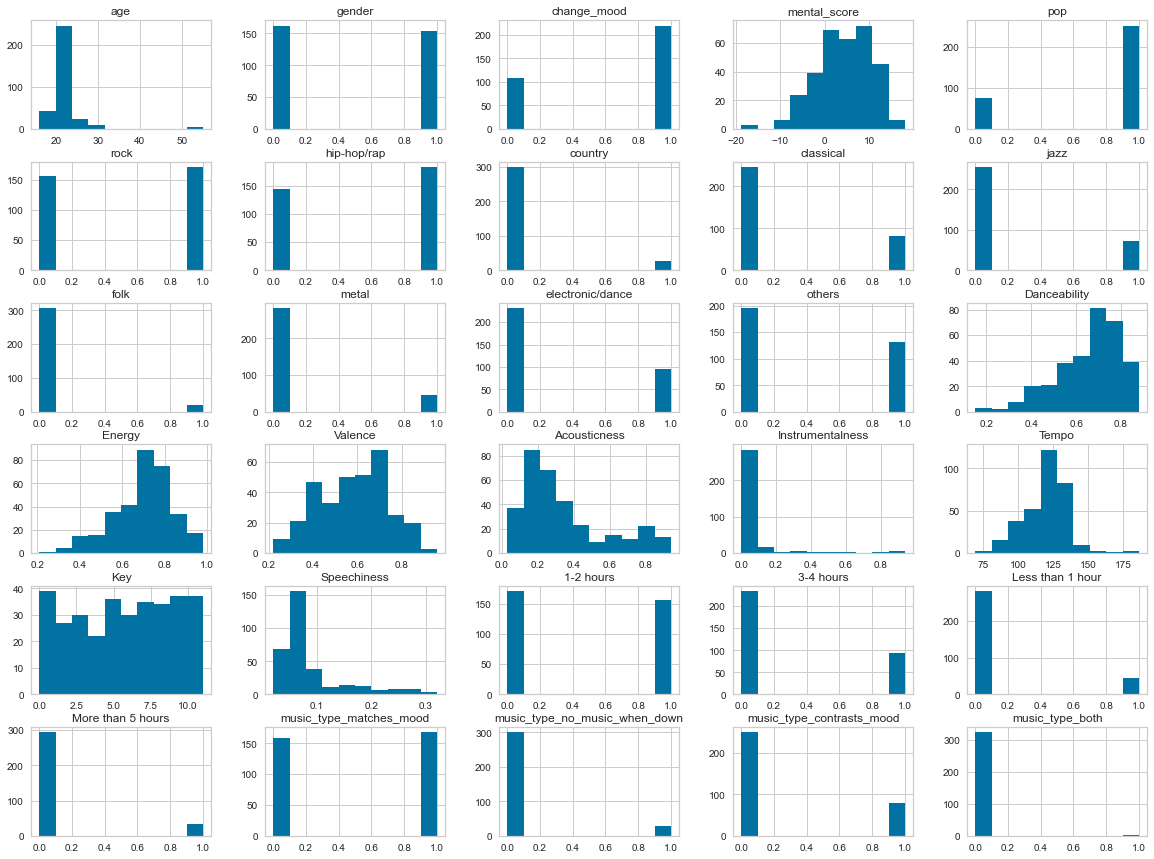

In [7]:
df.hist(figsize=(20, 15))
plt.show()

# Preprocess data

In [8]:
df.isna().sum()

age                               0
gender                           12
change_mood                       0
mental_score                      0
pop                               0
rock                              0
hip-hop/rap                       0
country                           0
classical                         0
jazz                              0
folk                              0
metal                             0
electronic/dance                  0
others                            0
Song                              0
Danceability                      0
Energy                            0
Valence                           0
Acousticness                      0
Instrumentalness                  0
Tempo                             0
Key                               0
Speechiness                       0
1-2 hours                         0
3-4 hours                         0
Less than 1 hour                  0
More than 5 hours                 0
music_type_matches_mood     

In [9]:
df = df.dropna()

In [10]:
df['mental_positive'] = np.where(df['mental_score'] > 0, 1, 0)

In [11]:
target = np.array(df.mental_positive)
x = df.drop(columns=['mental_score','mental_positive','Song'])

In [12]:
x.columns

Index(['age', 'gender', 'change_mood', 'pop', 'rock', 'hip-hop/rap', 'country',
       'classical', 'jazz', 'folk', 'metal', 'electronic/dance', 'others',
       'Danceability', 'Energy', 'Valence', 'Acousticness', 'Instrumentalness',
       'Tempo', 'Key', 'Speechiness', '1-2 hours', '3-4 hours',
       'Less than 1 hour', 'More than 5 hours', 'music_type_matches_mood',
       'music_type_no_music_when_down', 'music_type_contrasts_mood',
       'music_type_both'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.3,shuffle=True,stratify=target)

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1])

In [14]:
scaler=MinMaxScaler()
scaler.fit(X_train)
x_train=pd.DataFrame(scaler.transform(X_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(X_test),columns=x.columns)

# Decision Tree Classifier


In [15]:
DT3=DecisionTreeClassifier()
cv = StratifiedKFold(5)
param_val = [{'criterion':['entropy','gini'],'max_depth':[0,10],'min_samples_split':np.arange(2,10,2)}]
#grid search configuration
grid = GridSearchCV(DT3, param_val, cv = cv,scoring='roc_auc_ovr')
#fitting into our data
grid.fit(X_train, y_train)

/Users/tanyatonoran/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tanyatonoran/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tanyatonoran/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/tanyatonoran/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validat

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [0, 10],
                          'min_samples_split': array([2, 4, 6, 8])}],
             scoring='roc_auc_ovr')

In [16]:
print(grid.best_score_)
print(grid.best_params_)

0.6710938259601361
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}


In [17]:
y_pred_2=grid.predict(X_test)
y_pred_2_prob=grid.predict_proba(X_test)
metrics.roc_auc_score(y_test,y_pred_2,multi_class='ovr')

0.7314271749755621

/Users/tanyatonoran/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


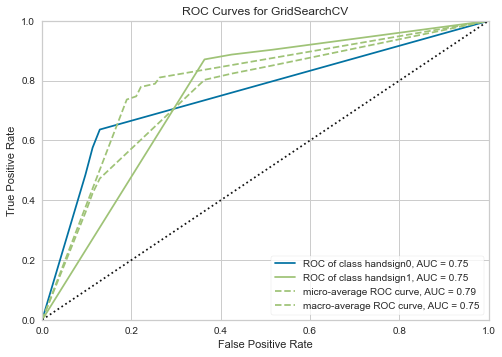

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [18]:
visualizer = ROCAUC(grid, classes=['handsign0', 'handsign1'])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test,y_test)        # Evaluate the model on the test data
visualizer.show()

In [19]:
dt_clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=10,
    min_samples_split=int(np.int64(8)),  # Ensure conversion to standard int
    random_state=100
)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=8, random_state=100)

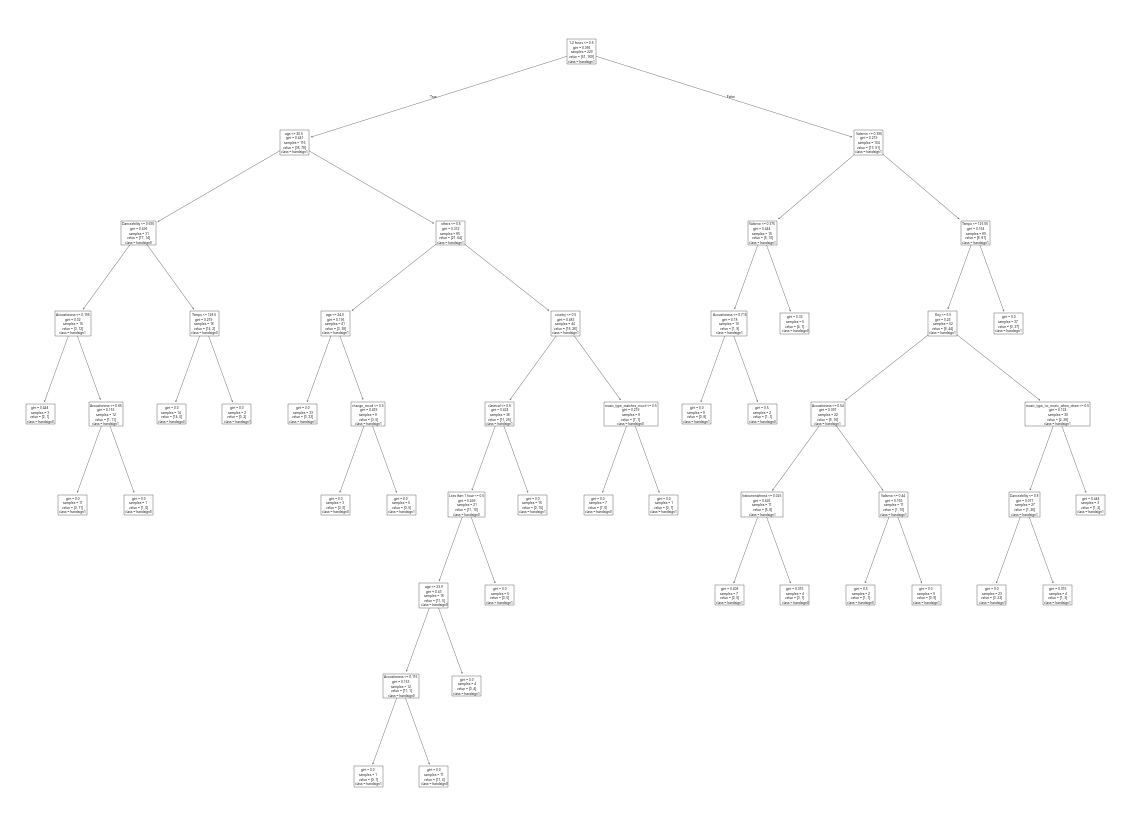

In [20]:
plt.figure(figsize=(20, 15))
plot_tree(dt_clf,feature_names=X_test.columns,class_names=['handsign0', 'handsign1'])
plt.show()


In [21]:
dt_clf.get_depth()

8

# Logistic

In [22]:
from sklearn.linear_model import LogisticRegression

### preprocess

In [23]:
X_train.iloc[:,:10].corr().round(2).mask((X_train.corr()<=0.7)&(X_train.corr()>=-0.7),'')

,age,gender,change_mood,pop,rock,hip-hop/rap,country,classical,jazz,folk
age,1.0,,,,,,,,,
gender,,1.0,,,,,,,,
change_mood,,,1.0,,,,,,,
pop,,,,1.0,,,,,,
rock,,,,,1.0,,,,,
hip-hop/rap,,,,,,1.0,,,,
country,,,,,,,1.0,,,
classical,,,,,,,,1.0,,
jazz,,,,,,,,,1.0,
folk,,,,,,,,,,1.0


In [24]:
X_train.iloc[:,10:].corr().round(2).mask((X_train.corr()<=0.7)&(X_train.corr()>=-0.7),'')

,metal,electronic/dance,others,Danceability,Energy,Valence,Acousticness,Instrumentalness,Tempo,Key,Speechiness,1-2 hours,3-4 hours,Less than 1 hour,More than 5 hours,music_type_matches_mood,music_type_no_music_when_down,music_type_contrasts_mood,music_type_both
metal,1.0,,,,,,,,,,,,,,,,,,
electronic/dance,,1.0,,,,,,,,,,,,,,,,,
others,,,1.0,,,,,,,,,,,,,,,,
Danceability,,,,1.0,,,,,,,,,,,,,,,
Energy,,,,,1.0,,-0.84,,0.87,,,,,,,,,,
Valence,,,,,,1.0,,,,,,,,,,,,,
Acousticness,,,,,-0.84,,1.0,,-0.85,,,,,,,,,,
Instrumentalness,,,,,,,,1.0,,,,,,,,,,,
Tempo,,,,,0.87,,-0.85,,1.0,,,,,,,,,,
Key,,,,,,,,,,1.0,,,,,,,,,


In [25]:
# Drop features with high correlation
X_train = X_train.drop(columns=['Tempo','Acousticness'])

### deal with imbalanced data

In [45]:
(df['mental_positive'] ==1).sum(), (df['mental_positive'] ==0).sum()

(231, 84)

In [42]:
from sklearn.utils import resample

df_positive = df[df['mental_positive'] == 1] #majority class
df_negative = df[df['mental_positive'] == 0]

df_downsampled = resample(df_positive, 
                                 replace=False,    # sample without replacement
                                 n_samples=84,     # to match minority class
                                 random_state=42)

df_balanced = pd.concat([df_downsampled, df_negative])

In [43]:
(df_balanced['mental_positive'] ==1).sum(), (df_balanced['mental_positive'] ==0).sum()

(84, 84)

In [36]:
lrc=LogisticRegression( multi_class='ovr',solver='saga',random_state=100)

#Train the model using the training sets
lrc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_test = lrc.predict(X_test.drop(columns=['Tempo','Acousticness']))
y_pred_train = lrc.predict(X_train)

/Users/tanyatonoran/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/tanyatonoran/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report: 
               precision    recall  f1-score   support

    negative       0.45      0.45      0.45        33
    positive       0.71      0.71      0.71        62

    accuracy                           0.62        95
   macro avg       0.58      0.58      0.58        95
weighted avg       0.62      0.62      0.62        95
 

Accuracy on train:   0.6409090909090909 

Accuracy on test:  0.6210526315789474 



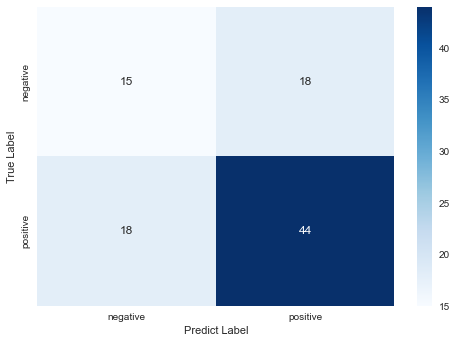

In [37]:
print("Classification Report: \n", metrics.classification_report(y_test,y_pred_test,target_names=['negative', 'positive']),'\n')
print("Accuracy on train:  ",lrc.score(X_train,y_train),'\n')
print("Accuracy on test: ",lrc.score(X_test.drop(columns=['Tempo','Acousticness']),y_test),'\n')
cf=metrics.confusion_matrix(y_test,y_pred_test)
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()